In [1]:
import pandas as pd
from facvae import FactorVAE
from facvae.data import change_freq, shift_ret, get_dataloaders
from facvae.pipeline import test_model, train_model
from facvae.backtesting import Backtester

In [2]:
# directories
dir_main = "E:/Others/Programming/py_vscode/projects/signal_mixing/"
dir_code = dir_main + "code/"
dir_data = dir_main + "data/"
dir_config = dir_main + "config/"
dir_result = dir_main + "result/"

In [3]:
# constants
E = 25
B = 16
N = 74
T = 20
C = 28
H = 10
M = 32
K = 8
h_prior_size = 16
h_alpha_size = 16
h_prior_size = 16
partition = [0.7, 0.2, 0.1]
lr = 0.0001
lmd = 1.0
max_grad = 1.0

================ Epoch 0 ================
batch: 0, loss: 86.65438842773438
batch: 10, loss: 71.27054595947266
batch: 20, loss: 96.58767700195312
batch: 30, loss: 87.56005859375
batch: 40, loss: 188.06736755371094
batch: 50, loss: 63.40589141845703
batch: 60, loss: 56.522953033447266
batch: 70, loss: 69.55935668945312
batch: 80, loss: 49.888465881347656
================ Epoch 1 ================
batch: 0, loss: 51.61811828613281
batch: 10, loss: 53.83730697631836
batch: 20, loss: 52.194366455078125
batch: 30, loss: 52.238704681396484
batch: 40, loss: 57.16986846923828
batch: 50, loss: 49.50271987915039
batch: 60, loss: 45.88557434082031
batch: 70, loss: 50.70454788208008
batch: 80, loss: 44.03400802612305
================ Epoch 2 ================
batch: 0, loss: 44.763648986816406
batch: 10, loss: 45.44346618652344
batch: 20, loss: 44.12469482421875
batch: 30, loss: 43.70692443847656
batch: 40, loss: 43.43128204345703
batch: 50, loss: 43.076393127441406
batch: 60, loss: 40.2894134521484

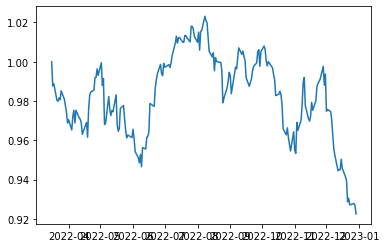

In [4]:
# model
fv = FactorVAE(C, H, M, K, h_prior_size, h_alpha_size, h_prior_size)

# data
df = pd.read_pickle(dir_data + "df_l1_comb.pickle")
df.sort_index(level=(0, 1), inplace=True)
df = shift_ret(df)
dl_train, dl_valid, dl_test = get_dataloaders(df, T, B, partition)

# train
train_model(fv, dl_train, lr, E, lmd=lmd, max_grad=max_grad)

# test
loss = test_model(fv, dl_test)
print("out-of-sample loss:", loss)

# predict
x, y = next(iter(dl_test))
mu_y, Sigma_y = fv.predict(x)

# backtest
len_test = next(iter(dl_test))[1].shape[0]
idx = pd.IndexSlice[df.index.get_level_values(0).unique()[-len_test:], :]
df = df.loc[idx]

df["factor"] = mu_y.flatten().cpu().numpy()
df = df[["factor", "ret"]]


bt = Backtester("factor", top_pct=0.25).feed(df).run()
bt.report()

In [5]:
next(iter(dl_test))[1].shape[0]

200

In [6]:
mu_y

tensor([[0.0296, 0.0260, 0.0190,  ..., 0.0279, 0.0355, 0.0269],
        [0.0236, 0.0216, 0.0367,  ..., 0.0261, 0.0289, 0.0279],
        [0.0355, 0.0268, 0.0235,  ..., 0.0318, 0.0348, 0.0261],
        ...,
        [0.0275, 0.0504, 0.0299,  ..., 0.0159, 0.0026, 0.0097],
        [0.0133, 0.0181, 0.0277,  ..., 0.0218, 0.0193, 0.0160],
        [0.0027, 0.0099, 0.0133,  ..., 0.0278, 0.0240, 0.0248]],
       device='cuda:0')

In [7]:
y

tensor([[-0.0166,  0.0130,  0.0089,  ...,  0.0535,  0.0023,  0.0325],
        [ 0.0282,  0.0135,  0.0059,  ...,  0.0553,  0.0020, -0.0018],
        [ 0.0024,  0.0078,  0.0039,  ...,  0.0524,  0.0032,  0.0516],
        ...,
        [ 0.0135,  0.0018,  0.0035,  ..., -0.0238, -0.0084, -0.0438],
        [-0.0242, -0.0162, -0.0153,  ..., -0.0516, -0.0017,  0.0105],
        [-0.0054,  0.0105,  0.0088,  ...,  0.0860,  0.0080, -0.0128]],
       device='cuda:0')

In [8]:
fv(x, y)[0]

tensor([[ 1.7452e-04,  8.5867e-05, -5.0436e-04,  ..., -3.7160e-04,
          7.9860e-05, -2.5563e-04],
        [-4.9686e-04, -7.6467e-04, -2.9119e-04,  ..., -4.2664e-04,
         -3.5384e-04, -4.7902e-04],
        [-6.6995e-05, -4.0725e-04, -5.3964e-04,  ..., -8.8622e-05,
         -5.6892e-05, -4.6887e-04],
        ...,
        [-1.2217e-03,  7.3569e-04,  4.3888e-04,  ..., -8.0376e-04,
         -2.2544e-03, -1.9979e-03],
        [-2.8684e-03, -2.0910e-03, -1.6357e-03,  ..., -9.7401e-04,
         -1.1731e-03, -1.3101e-03],
        [-2.0917e-03, -1.8594e-03, -2.2838e-03,  ..., -3.1836e-04,
         -4.3309e-04, -3.1878e-04]], device='cuda:0', grad_fn=<AddBackward0>)